In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates
import warnings
warnings.filterwarnings("ignore")

Import IHSG Data

In [60]:
start_date = "2020-01-01"
end_date = "2025-12-15"

df = yf.Ticker("BBRI.JK")
df = df.history(start=start_date, end=end_date)
del df["Dividends"]
del df["Stock Splits"]
forecastData = df.copy()
df.tail(20)

,Open,High,Low,Close,Volume
Date,,,,,
2025-11-17 00:00:00+07:00,3880.0,3950.0,3880.0,3940.0,140868100
2025-11-18 00:00:00+07:00,3950.0,3990.0,3930.0,3970.0,205257700
2025-11-19 00:00:00+07:00,3990.0,4000.0,3970.0,4000.0,107451000
2025-11-20 00:00:00+07:00,4020.0,4050.0,3990.0,3990.0,183008400
2025-11-21 00:00:00+07:00,3980.0,4000.0,3940.0,3960.0,112666100
2025-11-24 00:00:00+07:00,4000.0,4000.0,3940.0,3980.0,262302000
2025-11-25 00:00:00+07:00,3980.0,3980.0,3830.0,3830.0,396959100
2025-11-26 00:00:00+07:00,3800.0,3830.0,3780.0,3790.0,288419400
2025-11-27 00:00:00+07:00,3800.0,3810.0,3720.0,3740.0,283451800


Close Price Visualitation

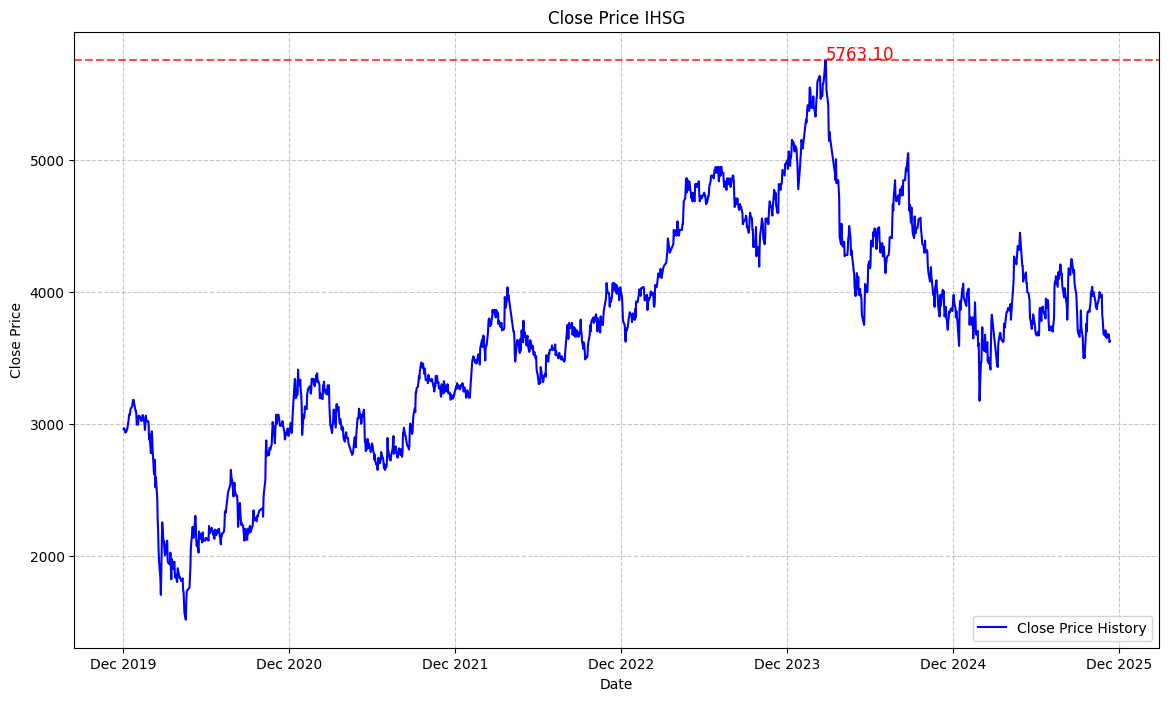

In [61]:
# Close price visualitation

plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=df.index, y='Close', label='Close Price History', color='blue')

max_price = df['Close'].max()
max_price_date = df['Close'].idxmax()

# Annotate the hight price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price IHSG')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Preprocessing

In [62]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
scaled_data

array([[0.34054349],
       [0.34212347],
       [0.33422364],
       ...,
       [0.5050764 ],
       [0.49566318],
       [0.49801648]])

In [63]:
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    for i in range(len(df) - sequence_length):
        sequences.append(df[i:i + sequence_length])
        labels.append(df[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

In [64]:
sequence_length = 30

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [65]:
X_train

array([[[0.34054349],
        [0.34212347],
        [0.33422364],
        ...,
        [0.35476335],
        [0.35634338],
        [0.35950345]],

       [[0.34212347],
        [0.33422364],
        [0.33896351],
        ...,
        [0.35634338],
        [0.35950345],
        [0.36582336]],

       [[0.33422364],
        [0.33896351],
        [0.3358035 ],
        ...,
        [0.35950345],
        [0.36582336],
        [0.36266341]],

       ...,

       [[0.68139283],
        [0.68354563],
        [0.68354563],
        ...,
        [0.8277799 ],
        [0.83316182],
        [0.79010679]],

       [[0.68354563],
        [0.68354563],
        [0.68139283],
        ...,
        [0.83316182],
        [0.79010679],
        [0.73090612]],

       [[0.68354563],
        [0.68139283],
        [0.70937855],
        ...,
        [0.79010679],
        [0.73090612],
        [0.74166985]]])

Training Data

In [66]:
model = Sequential()

# First Layer lSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=126, validation_data=(X_test, y_test))

Epoch 1/100
9/9 [==============================] - 2s 79ms/step - loss: 0.0963 - val_loss: 0.0326
Epoch 2/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0168 - val_loss: 0.0123
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0113 - val_loss: 0.0033
Epoch 4/100
9/9 [==============================] - 0s 22ms/step - loss: 0.0081 - val_loss: 0.0015
Epoch 5/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0015
Epoch 6/100
9/9 [==============================] - 0s 27ms/step - loss: 0.0051 - val_loss: 0.0016
Epoch 7/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 8/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 9/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0040 - val_loss: 0.0015
Epoch 10/100
9/9 [==============================] - 0s 15ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 11/100
9/9 [=

Model Evaluation

In [ ]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, predictions)
mape = mean_absolute_percentage_error(y_test_scaled, predictions) * 100

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}%")

9/9 [==============================] - 1s 8ms/step
Mean Squared Error: 18948.754699852347
Root Mean Squared Error: 137.65447577123072
R2 Score: 0.5512607171440317
Mean Absolute Percentage Error: 2.9120199459699245%


Prediction Future IHSG Price in 1 Month

In [ ]:
# we choose last 30 days or data ke belakang which the reasons use (-) in sequence_length
last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

X_predict = []
X_predict.append(last_30_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted IHSG Price: {predicted_price[0][0]}")

1/1 [==============================] - 0s 24ms/step
Predicted IHSG Price: 3670.3330078125


In [ ]:
future_days = 30

last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_30_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0, 0])

    new_scaled_data = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)

last_historical_date = df.index[-1].tz_localize(None).normalize()

future_dates_all = pd.date_range(
    start = last_historical_date,
    periods = future_days * 2,
    freq = 'B'
)


future_dates = future_dates_all[future_dates_all > last_historical_date][:future_days]

future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions})

1/1 [==============================] - 0s 10ms/step
        Date  Predicted Price IHSG
0 2025-12-15           3670.333008
1 2025-12-16           3670.333008
2 2025-12-17           3674.035156
3 2025-12-18           3680.036377
4 2025-12-19           3687.554199
5 2025-12-22           3696.142822
6 2025-12-23           3705.528076
7 2025-12-24           3715.513672
8 2025-12-25           3725.946045
9 2025-12-26           3736.751465


Visualitation IHSG Predictions

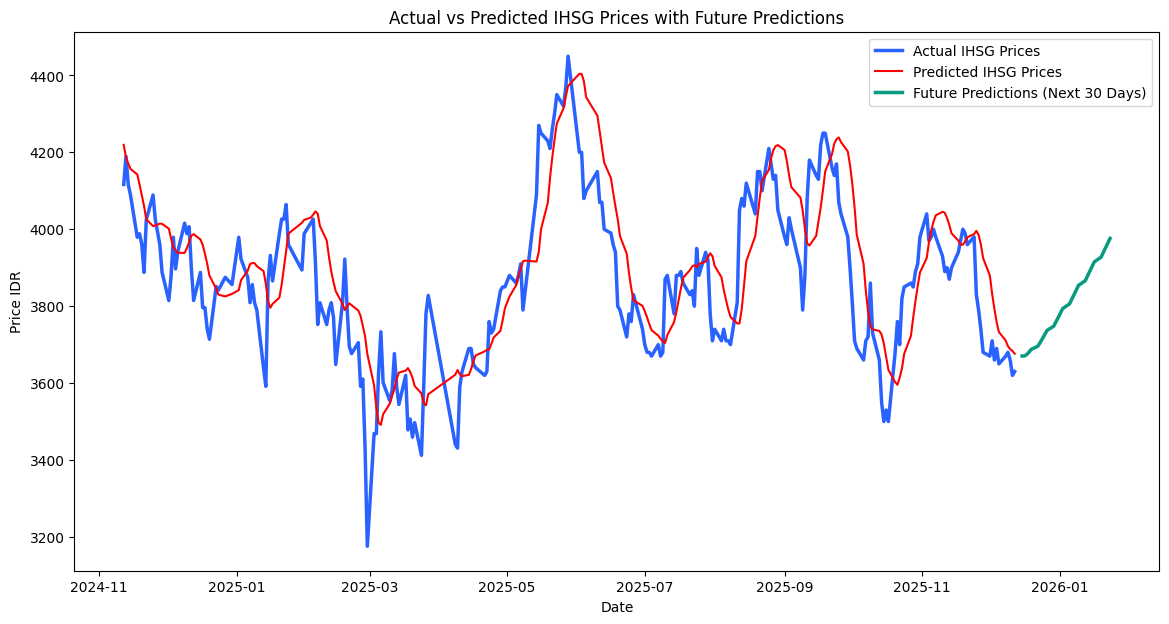

In [ ]:
plt.figure(figsize=(14, 7))

plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label='Actual IHSG Prices', color='#2962ff', linewidth=2.5)
plt.plot(df.index[-len(y_test_scaled):], predictions, label='Predicted IHSG Prices', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 30 Days)', color='#089981', linewidth=2.5)

plt.title('Actual vs Predicted IHSG Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price IDR')
plt.legend()
plt.show()

In [ ]:
# Transforming into DataFrame with pandas
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions
})

future_predictions_df.head()

,Date,Predicted Price IHSG
0,2025-12-15,3670.333008
1,2025-12-16,3670.333008
2,2025-12-17,3674.035156
3,2025-12-18,3680.036377
4,2025-12-19,3687.554199


In [ ]:
# calculate percentage change from the last actual close price
last_actual_price = df['Close'].iloc[-1]
percentage_change = ((future_predictions_df['Predicted Price IHSG'].iloc[-1] - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"

# print the percentage prediction
print(f"Percentage prediction for 30 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 30 days is: profit 9.54%
